In [2]:
!pip install pymc-bart
!pip install preliz

  Using cached preliz-0.16.0-py3-none-any.whl.metadata (6.1 kB)
Using cached preliz-0.16.0-py3-none-any.whl (519 kB)


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [4]:
import preliz as pz

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a machine learning algorithm that classifies things based on decision nodes that lead to a prediction after a series of nodes. They work kind of like a dichotomous key of going down the tree and choosing decision using predictors to end up at a ending node which gives a prediction.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is the number of levels of decision nodes between the original node and the lowest prediction node. If a decision tree is too deep that means that your model will have overfitting meaning it will perform well against test data, but not against real data. If a decision tree is not deep enough that means that your model will have underfitting meaning it's too simple and doesn't make very accurate predictions.

**Task4:**

How are BART models similar and different from a decision tree?

BART models and decision trees both use a tree based decisions to make predictions. However, BART models make predictions using multiple trees combined together while a model using a decision tree is just one tree.

**Task5**:

Why would we use a BART model instead of a decision tree?

A BART model is the better than a decision tree when your data is noisy and unstructured. A decision tree is good when you have a larger data set that is structured, but a BART model is good when you have a smaller data set that is very noisy. BART models also give uncertainty estimates, so if you need that you would use a BART model.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [9]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [14]:
features = ["flipper_length", "bill_depth", "bill_length"]
X = penguins[['flipper_length', 'bill_depth', 'bill_length']]
Y = penguins["body_mass"].to_numpy()

In [15]:
with pm.Model() as model_pengs:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_pengs = pm.sample(compute_convergence_checks=False)

Output()

In [16]:
pm.sample_posterior_predictive(idata_pengs, model_pengs, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

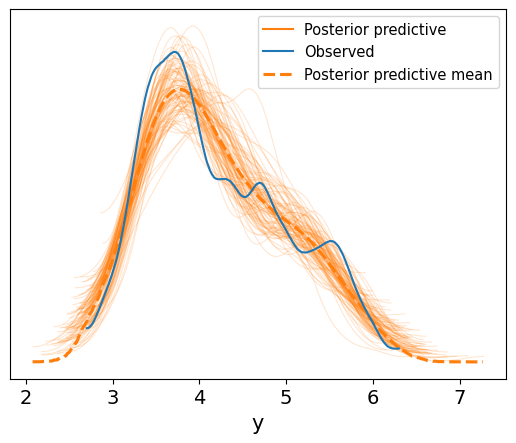

In [17]:
ax = az.plot_ppc(idata_pengs, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

<Axes: xlabel='flipper_length', ylabel='body_mass'>

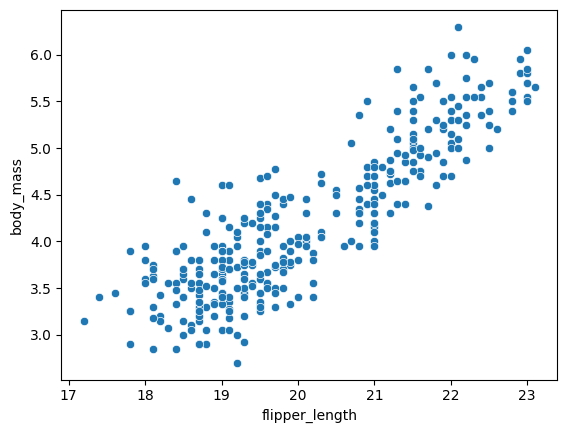

In [18]:
sns.scatterplot(data = penguins, y = 'body_mass', x = 'flipper_length')

In [19]:
posterior_mean = idata_pengs.posterior["μ"]

μ_hdi = az.hdi(ary=idata_pengs, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_pengs, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


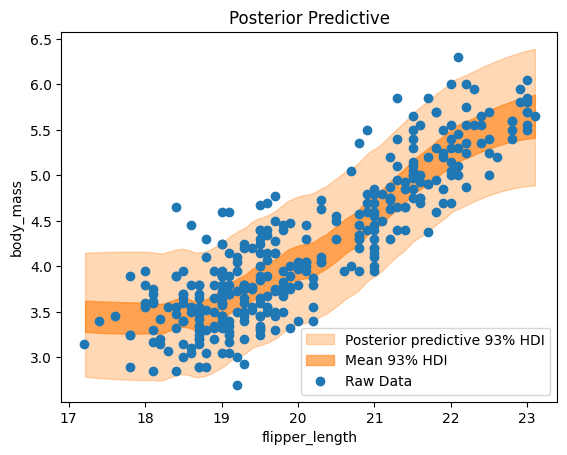

In [25]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive 93% HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 93% HDI"},
)
ax.plot(penguins['flipper_length'], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I do think it captures the true association between flipper length and body mass in penguins. The slope of the data changes when flipper length gets to about 19 and so does the posterior predictive.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

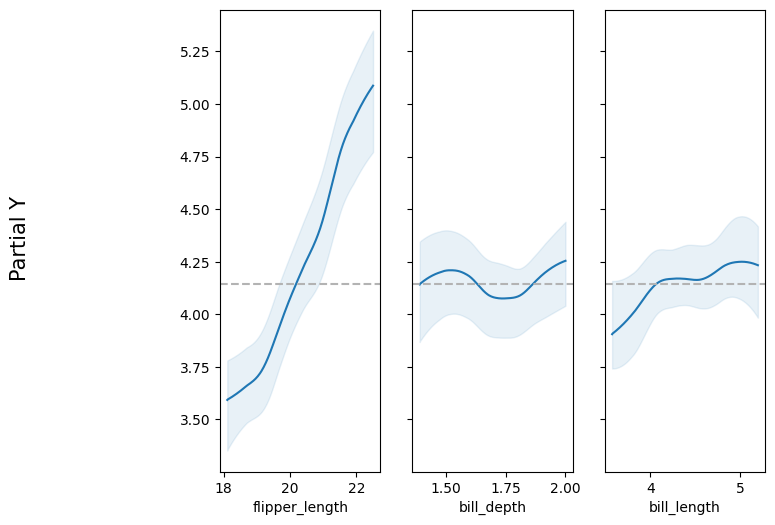

In [26]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

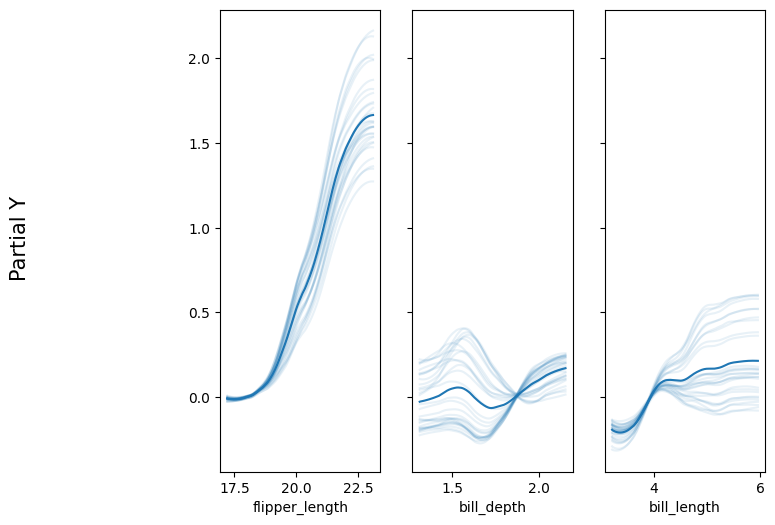

In [27]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [28]:
vi_pengs = pmb.compute_variable_importance(idata_pengs, μ_, X)

<Axes: ylabel='R²'>

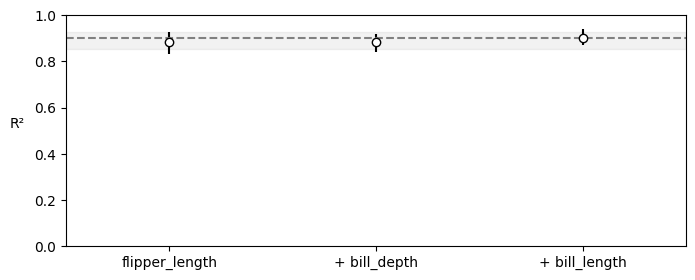

In [29]:
pmb.plot_variable_importance(vi_pengs)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

I think that flipper length is the most important variable when predicting the body mass of penguins. If we look at the pdp plot we can see that the flipper length has a very straightforward positive sloping graph. This matches the posterior predictive graph. The other two graphs go up and down not really showing much of a change in body mass as they go increase or decrease. This shows the variable that affects body mass the most is flipper length making it the most important.